In [22]:
# Importing Important libraries 

# For data cleaning and visualization
import math
import pandas as pd
import numpy as np
from numpy import array
from datetime import date, datetime, timedelta


# For model
from numpy import newaxis
import keras
from keras import optimizers, callbacks
from keras.layers import InputLayer, Input, Masking, Dense, Activation, Dropout, LSTM
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers, callbacks

from keras.layers import Dense, SimpleRNN, GRU
from keras.optimizers import SGD

# For saving the model
import pickle

# For Prediction 
from numpy import newaxis

# For model Evaluation
from sklearn import metrics
from sklearn.metrics import mean_squared_error

# For Plotting 
import matplotlib.pyplot as plt
from pylab import rcParams 

In [23]:
def create_windows(data, data_len, sequence_len=10):
  data_windows = []
  for i in range(data_len - sequence_len):
    data_windows.append(data[i : i+sequence_len])

  # set the type of training data     
  data_windows = np.array(data_windows).astype(float)
  return (data_windows)

In [24]:
def Normalize_data(data_windows):
  # number of windows formed 
  windows_no = data_windows.shape[0]
  cols_no = data_windows.shape[2]

  # initializing list to store normalized data
  normalized_data = []
  record_min=[]
  record_max=[]

  # normalizing begins
  for win_index in range(windows_no):
    normalized_window = []

    for col_index in range(0,1):
      # temporary column 
      t_col = data_windows[win_index, :, col_index]
      t_min = min(t_col)
      if (col_index == 0):
        record_min.append(t_min)
      t_col = t_col - t_min      
      t_max = max(t_col)
      if (col_index == 0):
        record_max.append(t_max)
      t_col = t_col/t_max
      normalized_window.append(t_col)
    
    for col_index in range(1,  cols_no):
      t_col = data_windows[win_index, :, col_index]
      normalized_window.append(t_col)

    normalized_window = np.array(normalized_window).T
    normalized_data.append(normalized_window)

  normalized_data=np.array(normalized_data)
  return (normalized_data, record_max, record_min)


In [25]:
def plot_training_loss(model_hist):
  # plotting the lose curve during model training
  plt.plot(model_hist.history['loss'])
  plt.title('Training Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train'],loc='upper left')
  plt.show()

In [26]:
def Model_Evaluation(actual_prices, predicted_prices):
  # Mean Absolute Error 
  MAE = metrics.mean_absolute_error(actual_prices, predicted_prices)
  # Mean Squared Error
  MSE = metrics.mean_squared_error(actual_prices, predicted_prices)
  # Root Mean Squared Error
  RMSE = np.sqrt(metrics.mean_squared_error(actual_prices, predicted_prices))

  # Mean Absolute Percentage Error in degrees
  errors = abs(actual_prices - predicted_prices)
  MAPE = 100 * (errors /actual_prices)

  # Model Accuracy
  Accuracy = 100 - np.mean(MAPE)
  return (Accuracy, MAE, MSE, RMSE)

In [27]:
def without_news(company, df):
  len_df = df.shape[0]
  # Data Preprocessing
  # splitting training and testing data
  cols = ['adj_close']
  cols2 = ['date']
  split = 0.85
  i_split = int(len(df) * split)
  data_train = df.get(cols).values[:i_split]
  data_test  = df.get(cols).values[i_split:]
  data_test2  = df.get(cols2).values[i_split:]

  len_train  = len(data_train)
  len_test   = len(data_test)
  len_train_windows = None
  # Creating Windows for Test Data
  sequence_length=10
  data_windows_test = create_windows(data_test,len(data_test),sequence_length)
  # get original y_test
  y_test_original = data_windows_test[:, -1, [0]]
  print('y_test_original.shape',y_test_original.shape)

  # Normalization of Test Data
  normalized_data_test, record_max_test, record_min_test = Normalize_data(data_windows_test)

  x_test = normalized_data_test[:, :-1]
  y_test = normalized_data_test[:, -1,[0]]

  # Train Data preparation
  data_windows = create_windows(data_train,len(data_train),sequence_length)
  normalized_data_train,rmax_train, rmin_train = Normalize_data(data_windows)

  x_train = normalized_data_train[:, :-1]
  y_train = normalized_data_train[:, -1,[0]]


  # Setting the parameter  
  input_dim=x_train.shape[2] #2
  input_timesteps=x_train.shape[1] #9
 
   # Simple RNN model
  model = Sequential()
  model.add(SimpleRNN(units = 60, activation = 'relu',return_sequences = True,input_shape=(input_timesteps, input_dim)))
  model.add(Dropout(0.2))
  model.add(SimpleRNN(units = 60,activation = 'relu', return_sequences = True))
  model.add(Dropout(0.2))
  model.add(SimpleRNN(units = 80, activation = 'relu',return_sequences = True))
  model.add(Dropout(0.2))
  model.add(SimpleRNN(units = 120,activation = 'relu', return_sequences = True))
  model.add(Dropout(0.2))
  model.add(Dense(units = 1))
  model.compile(optimizer='adam', loss = 'mean_squared_error', metrics=['mean_squared_error'])
  hist = model.fit(x_train, y_train, epochs=40, batch_size=32)

  plot_training_loss(hist)

  # Prediction of Test Data using the Training Model
  # Using the trained model for prediction and check the performance metrics
  train_predict = model.predict(x_train)
  test_predict = model.predict(x_test)
  # Multi-sequence Prediction
  # predicting x_test
  prediction_len = 1
  # x_test needs to be predicted 
  data = x_test
  predicted_vals = []
  window_size = sequence_length
  pre_win_no = int(len(data)/prediction_len)
  for i in range(pre_win_no):
    # access x_test window by window
    curr_frame = data[i*prediction_len]
    pred = []
    for j in range(prediction_len):
      # increase the dimension of current frame by one using newaxis, so that it can be fed to model for prediction
      model_predict = model.predict(curr_frame[newaxis,:,:])[0]
      pred.append(model_predict)
      # shift the current frame forward
      curr_frame = curr_frame[1:]
      # insert the currently predicted value in the frame
      # add the new predicted value at the end of window frame 
      curr_frame = np.insert(curr_frame, [window_size-2], pred[-1], axis=0)
    predicted_vals.append(pred)

  # Denormalizing the Prediction Results to get Predicted Adj Close Price

  pred_prices = []
  len_pre_win = int(len(data)/prediction_len)
  cnt=0
  for i in range(0,len_pre_win):
      for j in range(0,prediction_len):
        pred_prices.append(predicted_vals[i][j][0]*record_max_test[cnt]+record_min_test[cnt])
        cnt = cnt+1


  # Comparing Actual and Predicted Prices
  actual_prices = []
  for i in y_test_original.tolist():
    actual_prices.append(i[0])
  dates = []
  for i in data_test2.tolist():
    dates.append(i[0])
  dates = dates[len(dates)-len(actual_prices):]
  res = { 'date':dates,
        'Actual': actual_prices,
        'Predicted': pred_prices
        }
  df_compare = pd.DataFrame(res,columns = ['date','Actual','Predicted'])
  print(df_compare)
 
  # Performance Evaluation
  actual_prices = df_compare['Actual']
  predicted_prices = df_compare['Predicted']  

  Accuracy, MAE, MSE, RMSE = Model_Evaluation(actual_prices, predicted_prices)
  print("\n-----Model Evaluation-----------------------------------------------------\n")
  print("LSTM Model Loss = ", model.evaluate(x_test, y_test, verbose = 2))
  print("Model Accuracy = ", Accuracy)
  print("Mean Absolute Error = ", MAE," degrees")
  print("Mean Squared Error = ", MSE)
  print("Root Mean Squared Error = ", RMSE)
  print("\n--------------------------------------------------------------------------\n")

  

  return (hist, model, df_compare, Accuracy, MAE, MSE, RMSE)


In [28]:
company_tickers = ['AAPL','AMZN','ADM', 'GOOG', 'EBAY', 'XOM', 'ABT']

In [29]:
company_results = pd.DataFrame(columns=('company','MAE','MSE','Accuracy','RMSE'))
company_results

,company,MAE,MSE,Accuracy,RMSE


Evaluating Model for Company:  AAPL
y_test_original.shape (251, 1)
Epoch 1/40
46/46 [==============================] - 3s 14ms/step - loss: 0.2606 - mean_squared_error: 0.2606
Epoch 2/40
46/46 [==============================] - 1s 14ms/step - loss: 0.1081 - mean_squared_error: 0.1081
Epoch 3/40
46/46 [==============================] - 1s 14ms/step - loss: 0.1006 - mean_squared_error: 0.1006
Epoch 4/40
46/46 [==============================] - 1s 14ms/step - loss: 0.0961 - mean_squared_error: 0.0961
Epoch 5/40
46/46 [==============================] - 1s 14ms/step - loss: 0.0919 - mean_squared_error: 0.0919
Epoch 6/40
46/46 [==============================] - 1s 15ms/step - loss: 0.0906 - mean_squared_error: 0.0906
Epoch 7/40
46/46 [==============================] - 1s 14ms/step - loss: 0.0876 - mean_squared_error: 0.0876
Epoch 8/40
46/46 [==============================] - 1s 14ms/step - loss: 0.0879 - mean_squared_error: 0.0879
Epoch 9/40
46/46 [==============================] - 1s 14ms/s

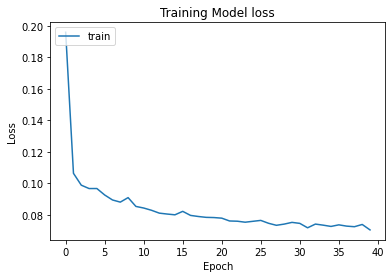

           date     Actual    Predicted
0    2019-01-30  37.715031   [38.15851]
1    2019-01-31  40.292267  [39.436165]
2    2019-02-01  40.582428  [39.583614]
3    2019-02-04  40.601936  [39.476795]
4    2019-02-05  41.755226  [40.695194]
..          ...        ...          ...
246  2020-01-22  78.347801   [77.77825]
247  2020-01-23  78.627464   [78.03881]
248  2020-01-24  79.006119     [78.485]
249  2020-01-27  78.778435  [78.522995]
250  2020-01-28  76.461929   [77.29214]

[251 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

8/8 - 1s - loss: 0.0638 - mean_squared_error: 0.0638
LSTM Model Loss =  [0.06381253153085709, 0.06381253153085709]
Model Accuracy =  [98.654915]
Mean Absolute Error =  0.7089087801625531  degrees
Mean Squared Error =  0.7082653753585842
Root Mean Squared Error =  0.8415850375087381

--------------------------------------------------------------------------

Evaluating Model for Company:  AMZN
y_test_original.shape (

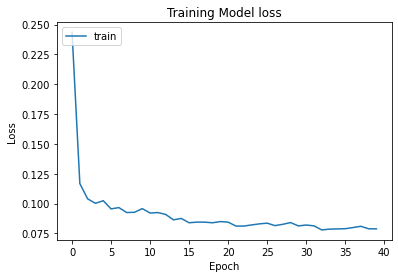

           date       Actual    Predicted
0    2019-04-12  1844.069946  [1835.8003]
1    2019-04-15  1843.060059  [1842.5132]
2    2019-04-17  1844.869995  [1842.5605]
3    2019-04-22  1864.819946  [1854.8284]
4    2019-04-23  1887.310059  [1873.3846]
..          ...          ...          ...
192  2020-01-30  1858.000000  [1860.3424]
193  2020-01-31  1870.680054  [1854.8055]
194  2020-02-03  2008.719971  [1962.3315]
195  2020-02-04  2004.199951  [1946.7816]
196  2020-02-05  2049.669922  [1987.5598]

[197 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

7/7 - 1s - loss: 0.0723 - mean_squared_error: 0.0723
LSTM Model Loss =  [0.07234717905521393, 0.07234717905521393]
Model Accuracy =  [98.746704]
Mean Absolute Error =  22.984401644789024  degrees
Mean Squared Error =  906.8459119532771
Root Mean Squared Error =  30.113882379282767

--------------------------------------------------------------------------

Evaluating Model for Company:  ADM
y

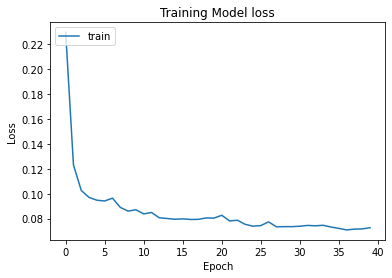

           date     Actual    Predicted
0    2019-04-12  40.507534  [39.850647]
1    2019-04-15  40.591747  [40.167244]
2    2019-04-17  40.554325  [40.340275]
3    2019-04-22  40.273605   [40.35351]
4    2019-04-23  39.918026  [40.409515]
..          ...        ...          ...
192  2020-01-30  41.956577  [42.843624]
193  2020-01-31  43.992935  [42.604652]
194  2020-02-03  42.993965   [42.64516]
195  2020-02-04  43.186077  [42.713497]
196  2020-02-05  43.579899  [42.868347]

[197 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

7/7 - 1s - loss: 0.0593 - mean_squared_error: 0.0593
LSTM Model Loss =  [0.059332311153411865, 0.059332311153411865]
Model Accuracy =  [98.75048]
Mean Absolute Error =  0.490243127503371  degrees
Mean Squared Error =  0.3570488386391249
Root Mean Squared Error =  0.5975356379657408

--------------------------------------------------------------------------

Evaluating Model for Company:  GOOG
y_test_original.shape (

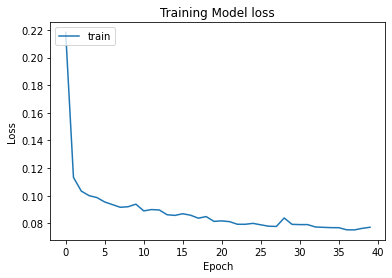

           date       Actual    Predicted
0    2019-04-12  1204.619995  [1205.7495]
1    2019-04-15  1217.869995   [1212.669]
2    2019-04-17  1221.099976  [1213.5874]
3    2019-04-22  1236.339966   [1222.978]
4    2019-04-23  1248.839966  [1229.9005]
..          ...          ...          ...
192  2020-01-30  1458.630005  [1470.9308]
193  2020-01-31  1455.839966  [1467.3815]
194  2020-02-03  1434.229980  [1451.6744]
195  2020-02-04  1485.939941  [1451.0377]
196  2020-02-05  1447.069946  [1450.8231]

[197 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

7/7 - 1s - loss: 0.0799 - mean_squared_error: 0.0799
LSTM Model Loss =  [0.07990826666355133, 0.07990826666355133]
Model Accuracy =  [98.651085]
Mean Absolute Error =  16.426312286841693  degrees
Mean Squared Error =  414.1445328506269
Root Mean Squared Error =  20.350541340481016

--------------------------------------------------------------------------

Evaluating Model for Company:  EBAY


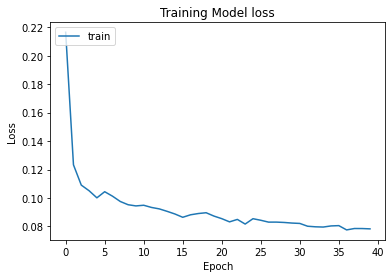

           date     Actual    Predicted
0    2019-04-12  35.292530   [36.06629]
1    2019-04-15  35.146770   [35.77549]
2    2019-04-17  35.205078   [35.73635]
3    2019-04-22  34.952431  [35.592197]
4    2019-04-23  35.127342  [35.582634]
..          ...        ...          ...
192  2020-01-30  33.982201   [34.73423]
193  2020-01-31  34.453903   [34.52821]
194  2020-02-03  32.979836  [33.853554]
195  2020-02-04  33.795483  [33.870686]
196  2020-02-05  36.763275  [34.466637]

[197 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

7/7 - 1s - loss: 0.0918 - mean_squared_error: 0.0918
LSTM Model Loss =  [0.0918339267373085, 0.0918339267373085]
Model Accuracy =  [98.65427]
Mean Absolute Error =  0.49803603119051415  degrees
Mean Squared Error =  0.3845037892061942
Root Mean Squared Error =  0.6200836953236185

--------------------------------------------------------------------------

Evaluating Model for Company:  XOM
y_test_original.shape (197

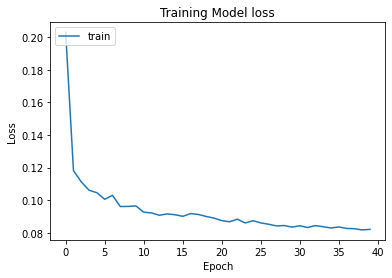

           date     Actual    Predicted
0    2019-04-12  72.001968  [72.462425]
1    2019-04-15  71.097000     [72.147]
2    2019-04-17  70.859787   [72.15416]
3    2019-04-22  71.545097  [72.319275]
4    2019-04-23  72.836647   [71.83018]
..          ...        ...          ...
192  2020-01-30  58.377277  [59.834187]
193  2020-01-31  58.996475  [59.755196]
194  2020-02-03  56.565224  [58.449257]
195  2020-02-04  55.299515  [57.303493]
196  2020-02-05  54.607475    [56.7197]

[197 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

7/7 - 1s - loss: 0.0834 - mean_squared_error: 0.0834
LSTM Model Loss =  [0.08338087052106857, 0.08338087052106857]
Model Accuracy =  [98.74304]
Mean Absolute Error =  0.8056586599592028  degrees
Mean Squared Error =  0.9743541947925414
Root Mean Squared Error =  0.9870938125591414

--------------------------------------------------------------------------

Evaluating Model for Company:  ABT
y_test_original.shape (19

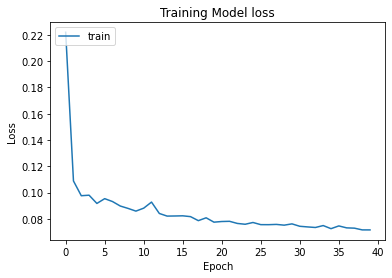

           date     Actual    Predicted
0    2019-04-12  76.076523  [76.481155]
1    2019-04-15  75.901398   [76.27793]
2    2019-04-17  75.405174   [75.91529]
3    2019-04-22  70.910042   [72.69881]
4    2019-04-23  72.495987   [72.65642]
..          ...        ...          ...
192  2020-01-30  87.775566    [89.4922]
193  2020-01-31  87.795273   [89.68541]
194  2020-02-03  85.806183   [88.85958]
195  2020-02-04  85.727409   [88.36226]
196  2020-02-05  86.879509   [87.10758]

[197 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

7/7 - 1s - loss: 0.0886 - mean_squared_error: 0.0886
LSTM Model Loss =  [0.08855275809764862, 0.08855275809764862]
Model Accuracy =  [98.867294]
Mean Absolute Error =  0.9179410595579196  degrees
Mean Squared Error =  1.3789166144558067
Root Mean Squared Error =  1.1742728023997688

--------------------------------------------------------------------------



In [30]:
for i in range(len(company_tickers)):
  company = company_tickers[i]
  print("Evaluating Model for Company: ",company)
  df_name = "CS_stock_and_news_"+company+".csv"
  # Load dataset of a particular company
  df = pd.read_csv(df_name, index_col=0)
  hist, model, df_compare, Accuracy, MAE, MSE, RMSE = without_news(company, df)
  company_results = company_results.append({'company': company, 'MAE': MAE,'MSE':MSE, 'Accuracy': Accuracy, 'RMSE':RMSE}, ignore_index=True)


In [31]:
company_results

,company,MAE,MSE,Accuracy,RMSE
0,AAPL,0.708909,0.708265,[98.654915],0.841585
1,AMZN,22.984402,906.845912,[98.746704],30.113882
2,ADM,0.490243,0.357049,[98.75048],0.597536
3,GOOG,16.426312,414.144533,[98.651085],20.350541
4,EBAY,0.498036,0.384504,[98.65427],0.620084
5,XOM,0.805659,0.974354,[98.74304],0.987094
6,ABT,0.917941,1.378917,[98.867294],1.174273


In [32]:
# Mean Accuracy for With news
mean_results = company_results.mean(axis = 0)
mean_results

MAE             6.11879
MSE             189.256
Accuracy    [98.723976]
RMSE            7.81214
dtype: object

In [34]:
now = datetime.now()
current_time = now.strftime("%H%M%S")
name = "P19_RNN_company_specific_without_news"+current_time+".csv"
company_results.to_csv(name)